In [198]:
#Import des modules utiles

import numpy as np
import pandas as pd 
import os
import igraph as ig

os.listdir()


['.ipynb_checkpoints',
 'Pop2x_v2.csv',
 'DataGeno2x.csv',
 'Brouillon_généalogie_rosier.ipynb',
 'essai_4x.csv']

In [105]:
#Chargement des données et Preprocessing

data1 = pd.read_csv('DataGeno2x.csv')
data2 = pd.read_csv('Pop2x_v2.csv')
data3 = pd.read_csv('essai_4x.csv')

data1['1.1'] = np.arange(1,7) #relister la dernière colonne 

# Définir la colonne '1.1' comme indice
data1 = data1.set_index(data1.columns[-1])

# Liste des noms de colonnes contenant des zéros
colonnes_a_supprimer = [colonne for colonne in data1.columns if (data1[colonne] == 0).all()]

# Supprimez les colonnes contenant uniquement des zéros
data1 = data1.drop(columns=colonnes_a_supprimer)

data1.index.name = 'index'


# Créez un dictionnaire de correspondance des noms de colonnes
nouveaux_noms = {'10':'marqueur_1.0','10.1':'marqueur_1.1',
                 '50':'marqueur_2.0','60':'marqueur_2.1',
                 '100':'marqueur_3.0','100.1':'marqueur_3.1',
                 '140':'marqueur_4.0','140.1':'marqueur_4.1',
                '1':'generation'}

data1.rename(columns= nouveaux_noms, inplace=True)

data1

,marqueur_1.0,marqueur_1.1,marqueur_2.0,marqueur_2.1,marqueur_3.0,marqueur_3.1,marqueur_4.0,marqueur_4.1,generation
index,,,,,,,,,
1,10,20,60,70,110,110,150,160,1
2,30,30,60,70,130,130,150,160,1
3,10,40,80,90,140,140,150,150,1
4,10,20,60,60,100,110,140,160,2
5,10,20,70,90,110,140,150,150,2
6,10,10,60,60,100,110,140,160,3


In [106]:
# Générer les enfants virtuels à l'aide de deux parents pour un marqueur donné

def generEnf_Enf(P1,P2,m): 
    #P1 et P2 sont des int associés à l'indice des parents
    #m est est un entier compris entre 1 et 4 car il y a 4 caractéristiques
    
    P1_a,P1_b =data1.loc[P1,[f'marqueur_{m}.0',f'marqueur_{m}.1']] 
    #permet de stocker les allèles du parent 1 sur le marqueur m
    
    P2_a,P2_b =data1.loc[P2,[f'marqueur_{m}.0',f'marqueur_{m}.1']] 
    #permet de stocker les allèles du parent 2 sur le marqueur m
    return np.array([[P1_a,P2_a],[P1_a,P2_b],[P1_b,P2_a],[P1_b,P2_b]])

generEnf_Enf(1,1,1)

array([[10, 10],
       [10, 20],
       [20, 10],
       [20, 20]])

In [107]:
# donner pour un marqueur donné et une liste d'enfants virtuels pour un couple de parent
#le nombre  de fois ou l'enfant réel apparaît.


def compteEnf_virt_reel(P1,P2,E,m): 
    #m est est un entier compris entre 1 et 4
    # E est un entier pour une ligne donnée 
    
    E_virt = generEnf_Enf(P1,P2,m)
    #liste des enfants virtuel
    
    E_a,E_b =data1.loc[E,[f'marqueur_{m}.0',f'marqueur_{m}.1']] 
    #E_a et E_b permet de stocker les allèles de l'enfant sur le marqueur m
    c = 0 # c est un compteur
    
    for i in range(4): #Se déplacer sur les 4 cas possibles de la liste
        
        # Tester si la configuration enfant est présente dans la liste à permutation près 
        if list(E_virt[i,:]) == [E_a,E_b] or list(E_virt[i,:]) == [E_b,E_a]: 
            #list(E_virt[i,:]) convertir en liste tester l'égalité
            c+=1 #incrémante d'un si vrai
            
            #Permet de faire des affichages pour mieux comprendre
            '''print(E_virt[i,:], [E_a,E_b], list(E_virt[i,:]) == [E_a,E_b] )
            print('et')
            print(E_virt[i,:], [E_b,E_a], list(E_virt[i,:]) == [E_b,E_a])'''
            
    return c# nb de cas de ressemblance sur les 4 possibles
        
compteEnf_virt_reel(1,1,4,1)      

2

In [138]:
def Proba_Par_Enf(P1,P2,E):
    p=0
    I = range(1,7)
    if (P1 not in I) or (P2 not in I) or (E not in I):
        raise ValueError("les index rentrés ne sont pas bons")
    elif (data1.iloc[P1-1]['generation'] >= data1.iloc[E-1]['generation']) or (data1.iloc[P2-1]['generation'] >= data1.iloc[E-1]['generation']):
        # les indices python commence à 0 et non à 1, donc on abaise tout de 1 
        return p
    else:
        for m in range(1,5):
            p+= compteEnf_virt_reel(P1,P2,E,m)/4
        return p/4

#Un exemple 
Proba_Par_Enf(1,1,4)



0.1875

Text(0.5, 1.0, "matrice des probablités pour l'enfant 4")

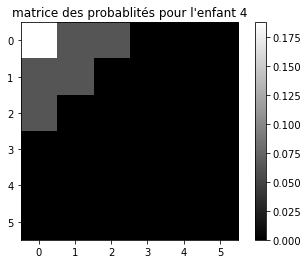

In [192]:
import matplotlib.pyplot as plt

def Matrix_Proba(E):
    n= len(data1)
    Matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            Matrix[i,j] = Proba_Par_Enf(i+1,j+1,E)
    return Matrix
            
plt.imshow(Matrix_Proba(4),cmap='gray')
plt.colorbar()
plt.title("matrice des probablités pour l'enfant 4")

In [225]:
def Recup_Parents_max(E):
    M = Matrix_Proba(E)
    P1,P2 = np.unravel_index(np.argmax(M),M.shape)
    return [E,P1+1,P2+1,-np.log(M.max())]

Liste_pedigree = []
for e in range(4,7):
    Liste_pedigree.append(Recup_Parents_max(e))

Liste_pedigree

[[4, 1, 1, 1.6739764335716716],
 [5, 1, 3, 0.6931471805599453],
 [6, 4, 4, 0.5753641449035618]]

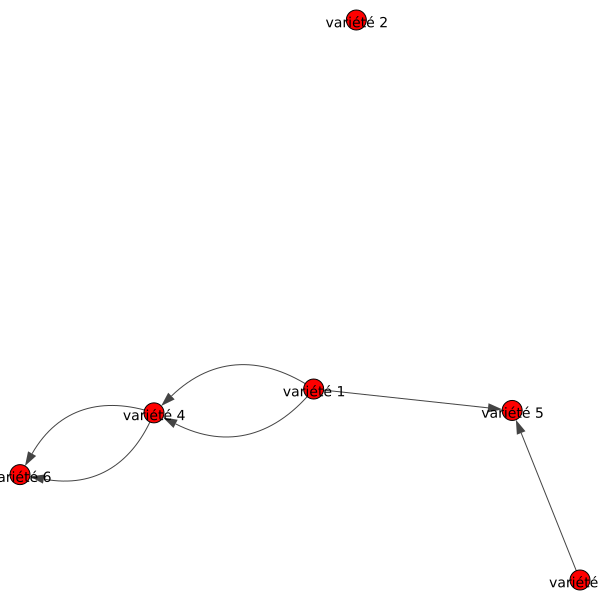

In [267]:

n = len(data1)
# Créez un graphe non orienté vide
g = ig.Graph(directed = True)
# Spécifiez un nom pour chaque nœud
node_names = [f'variété {i+1}' for i in range(n) ]

# Ajoutez 6 noeuds à l'arbre
g.add_vertices(len(node_names)) 




# Ajoutez des arêtes pour connecter les noeuds et former un arbre
for i in range(len(Liste_pedigree)):
    
    a,b,c = Liste_pedigree[i][0]-1, Liste_pedigree[i][1]-1,Liste_pedigree[i][2] -1
    
    g.add_edges([(b, a),(c,a)]) 
    # Par exemple, pour créer deux branche avec les flèches qui vont bien 
    
#layout = g.layout('circle')
    
ig.plot(g,vertex_label=node_names)#, bbox=(350,500))

